<a href="https://colab.research.google.com/github/Koettinl/IR-TinyML-Messedemo/blob/main/TinyML_Messedemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set Environment


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np

print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


### Data Preparation

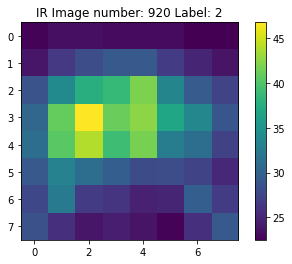

Min:  18.25 °C	Max:  64.0 °C
   19.25  19.75   20.5     20  20.5.1  ...  20.25.2   21.4  20.25.3  21.5.2  21.25.6
0  20.25  20.25  20.50  19.25   20.50  ...    20.50  20.50    19.75   20.75    21.75
1  20.25  20.25  20.75  20.00   20.75  ...    20.50  20.75    20.25   20.75    22.00
2  20.50  20.25  20.00  19.75   20.50  ...    20.75  20.75    20.75   21.50    22.25
3  20.50  20.25  20.50  20.00   20.50  ...    21.00  21.25    20.75   21.50    22.00
4  20.25  19.75  20.50  19.75   20.50  ...    21.00  20.75    20.75   21.25    22.25

[5 rows x 64 columns]
      19.25     19.75      20.5  ...   20.25.3    21.5.2   21.25.6
0  0.043716  0.043716  0.049180  ...  0.032787  0.054645  0.076503
1  0.043716  0.043716  0.054645  ...  0.043716  0.054645  0.081967
2  0.049180  0.043716  0.038251  ...  0.054645  0.071038  0.087432
3  0.049180  0.043716  0.049180  ...  0.054645  0.071038  0.081967
4  0.043716  0.032787  0.049180  ...  0.054645  0.065574  0.087432

[5 rows x 64 columns]


In [ ]:
# input data
url = "/content/drive/MyDrive/Colab Notebooks/messedemonstrator 3 states/klassifizierung_messedemo_261021.csv"

num_clases = 3
# 8x8 image
input = 64

# read data set
dataframe = pd.read_csv(url, parse_dates=True)
h,w = dataframe.shape
# separate date from data set
dataframe.iloc[0:h, 0] = pd.to_datetime(dataframe.iloc[0:h,0])
# Separate labels from the Data set
'''df_labels = dataframe.iloc[0:h, w-1]'''
df_label = dataframe.pop(dataframe.columns[w-1])
df = dataframe.iloc[0:h, 1:w-1]

# Visual representation

row = 920 
  #data = dataframe[row:row+1]
data = df.iloc[row,0:w-1]
data = np.array(data, dtype = np.float32 )
size = int(np.sqrt(data.size))
data = data.reshape(size, size)

plt.imshow(data)
plt.title('IR Image number: '+str(row)+' Label: '+str(df_label[row]))
plt.colorbar()
plt.show()

# prepare for NN
min = df.min().min()
max = df.max().max()
print("Min: ", min,"°C\tMax: ", max, "°C")

df_normalized = (dataframe.iloc[0:h, 1:w-1] - min) / (max - min)
print(df.head())
print(df_normalized.head())

In [ ]:
# Set training and test data and labels
training_dataset = df_normalized.sample(frac=0.8, random_state=0)
testing_dataset =  df_normalized.drop(training_dataset.index)
#training_dataset = np.expand_dims(training_dataset, axis=0)

# reshape training dataset to a 8x8 np.array
training_h, training_w = training_dataset.shape
training_dataset = np.array(training_dataset, dtype=np.float32)
training_dataset = training_dataset.reshape(training_h, size, size,-1)
#training_dataset = np.expand_dims(training_dataset, 0)

# reshape testing dataset to a 8x8 np.array
testing_h, testing_w = testing_dataset.shape
testing_dataset = np.array(testing_dataset, dtype=np.float32)
testing_dataset = testing_dataset.reshape(testing_h, size, size,-1)
#testing_dataset = np.expand_dims(testing_dataset, 0)
print(testing_dataset.shape)

# training and test labeling
training_labels = df_label.sample(frac=0.8, random_state=0)
testing_labels =  df_label.drop(training_labels.index)

(1073, 8, 8, 1)


# **Train the model**

In [ ]:
batchsize = 32

model = tf.keras.Sequential()
#model.add(layers.Conv2D(16, (3,3), activation='sigmoid', input_shape=(8,8,1)))
model.add(layers.Flatten(input_shape=(8,8,1))) #input_shape=(8,8,1)
model.add(layers.Dense(32, activation= 'sigmoid',input_shape=(64,)))
model.add(layers.Dense(16,activation= 'sigmoid'))
model.add(layers.Dense(num_clases, activation= 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 2,659
Trainable params: 2,659
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate= 0.005, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'],)
    #optimizer=Adam(learning_rate= 0.00005), loss = 'categorical_crossentropy', metrics = ['accuracy'],)

history = model.fit(training_dataset, 
                    to_categorical(training_labels), 
                    validation_data=(testing_dataset, testing_labels), 
                    validation_split=0.2, epochs = 500, batch_size = batchsize)

Epoch 1/500
108/108 [==============================] - 1s 6ms/step - loss: 1.0958 - accuracy: 0.3727 - val_loss: 1.0760 - val_accuracy: 0.3970
Epoch 2/500
108/108 [==============================] - 0s 2ms/step - loss: 1.0757 - accuracy: 0.4808 - val_loss: 1.0629 - val_accuracy: 0.5867
Epoch 3/500
108/108 [==============================] - 0s 2ms/step - loss: 1.0588 - accuracy: 0.5318 - val_loss: 1.0351 - val_accuracy: 0.3970
Epoch 4/500
108/108 [==============================] - 0s 2ms/step - loss: 1.0337 - accuracy: 0.5399 - val_loss: 1.0046 - val_accuracy: 0.4307
Epoch 5/500
108/108 [==============================] - 0s 2ms/step - loss: 0.9971 - accuracy: 0.6434 - val_loss: 0.9647 - val_accuracy: 0.7322
Epoch 6/500
108/108 [==============================] - 0s 2ms/step - loss: 0.9466 - accuracy: 0.6774 - val_loss: 0.9006 - val_accuracy: 0.7020
Epoch 7/500
108/108 [==============================] - 0s 2ms/step - loss: 0.8847 - accuracy: 0.7369 - val_loss: 0.8319 - val_accuracy: 0.7544

34/34 [==============================] - 0s 1ms/step - loss: 0.0386 - accuracy: 0.9907


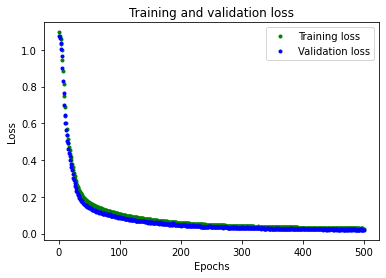

In [ ]:
model.evaluate(
    testing_dataset, 
    to_categorical(testing_labels)
)

# Graphing the History
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs= range(1,len(loss)+1)

plt.plot(epochs, loss, 'g.', label= 'Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show() 